In [ ]:
!pip install casadi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 MB 9.3 MB/s eta 0:00:00


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      801
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      102

Total number of variables............................:      302
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      202
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.79e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

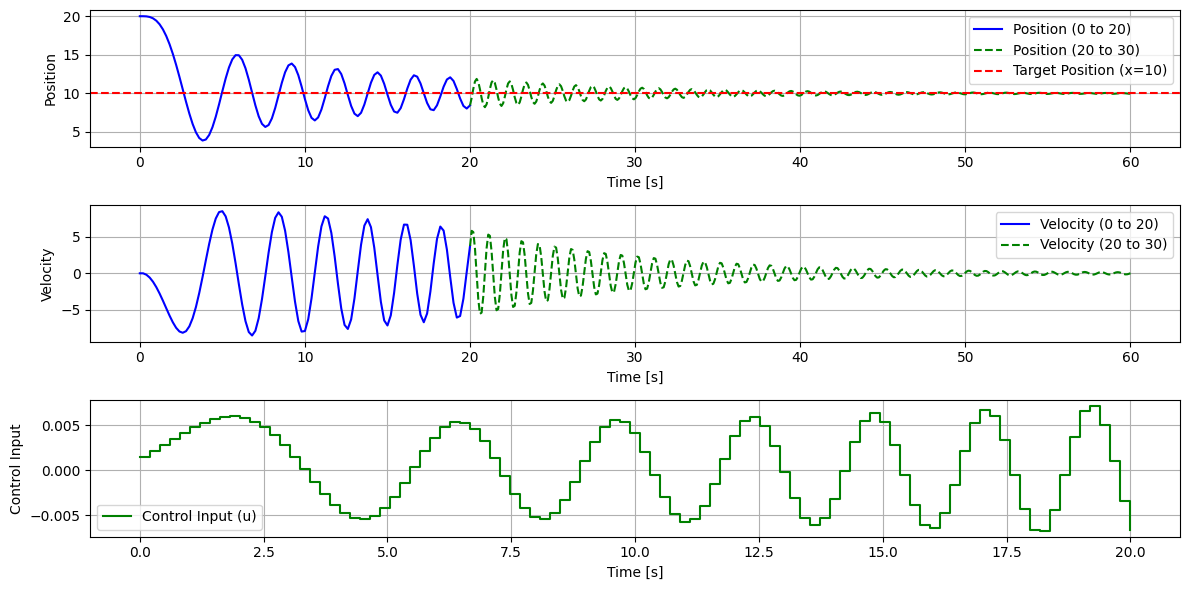

Final position after T=30: 9.953641487740438
Final velocity after T=30: 0.0139677327369878


In [ ]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

# Parameters
m = 10  # Mass
n = 0.9  # Damping coefficient
k = 1.0  # Spring constant
x_target = 10.0  # Target position (steady-state value)
x_start = 20.0  # Initial position
N = 100  # Number of control intervals
T = 20.0  # Fixed target time for settling

# Create an optimization problem
opti = ca.Opti()

# Decision variables
X = opti.variable(2, N + 1)  # States: [position, velocity]
pos = X[0, :]  # Position
vel = X[1, :]  # Velocity
U = opti.variable(1, N)  # Control inputs

# Dynamics (centered around x_target)
f = lambda x, u: ca.vertcat(x[1], (u - n * x[1] - k * (x[0] - x_target)) / m)

# Time step
dt = T / N

# Define the cost function components
input_cost = 0
terminal_error_cost = 0

# Dynamic constraints
for k in range(N):
    # Runge-Kutta 4 integration
    k1 = f(X[:, k], U[:, k])
    k2 = f(X[:, k] + dt / 2 * k1, U[:, k])
    k3 = f(X[:, k] + dt / 2 * k2, U[:, k])
    k4 = f(X[:, k] + dt * k3, U[:, k])
    x_next = X[:, k] + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

    # Enforce dynamics
    opti.subject_to(X[:, k + 1] == x_next)

    # Accumulate cost for control effort
    input_cost += 10 * U[:, k]**2

# Terminal cost for position and velocity errors
terminal_error_cost += (X[0, -1] - x_target)**2 + (X[1, -1])**2

# Objective
opti.minimize(input_cost + terminal_error_cost)

# Boundary conditions
opti.subject_to(pos[0] == x_start)  # Initial position starts at 200
opti.subject_to(vel[0] == 0)  # Initial velocity is 0

# Initial guesses
opti.set_initial(pos, np.linspace(x_start, x_target, N + 1))
opti.set_initial(vel, 0)
opti.set_initial(U, 0)

# Solve the optimization problem
opti.solver('ipopt')  # Set IPOPT solver
sol = opti.solve()

# Extract solutions
pos_sol = sol.value(pos)
vel_sol = sol.value(vel)
u_sol = sol.value(U)

# Parameters for continuation beyond T = 20
extra_time = 40  # Simulate for an additional 10 seconds beyond T
extra_steps = 400  # Number of extra time steps for the simulation
extended_time = np.linspace(T, T + extra_time, extra_steps)

# Extract final control input from the optimization result (constant for continuation)
u_final = u_sol[-1]

# Create an extended time trajectory for position and velocity
extended_pos = [float(pos_sol[-1])]  # Starting from the final position
extended_vel = [float(vel_sol[-1])]  # Starting from the final velocity

# Simulate the system dynamics beyond T = 20 using the final control input (u_final)
for i in range(1, extra_steps):
    # Get the current state (position and velocity)
    current_pos = extended_pos[-1]
    current_vel = extended_vel[-1]

    # Use the system dynamics (same as before) to compute the next state
    k1 = f(ca.vertcat(current_pos, current_vel), u_final)
    k2 = f(ca.vertcat(current_pos + dt / 2 * k1[0], current_vel + dt / 2 * k1[1]), u_final)
    k3 = f(ca.vertcat(current_pos + dt / 2 * k2[0], current_vel + dt / 2 * k2[1]), u_final)
    k4 = f(ca.vertcat(current_pos + dt * k3[0], current_vel + dt * k3[1]), u_final)

    # Calculate the next state using Runge-Kutta 4 integration
    next_pos = float(current_pos + dt / 6 * (k1[0] + 2 * k2[0] + 2 * k3[0] + k4[0]))
    next_vel = float(current_vel + dt / 6 * (k1[1] + 2 * k2[1] + 2 * k3[1] + k4[1]))

    # Append to the extended lists
    extended_pos.append(next_pos)
    extended_vel.append(next_vel)

# Plot the position and velocity evolution after T = 20
plt.figure(figsize=(12, 6))

# Plot the full trajectory of position (original and extended)
plt.subplot(3, 1, 1)
plt.plot(np.linspace(0, T, N + 1), pos_sol, label="Position (0 to 20)", color='blue')
plt.plot(extended_time, extended_pos, label="Position (20 to 30)", color='green', linestyle='--')
plt.axhline(x_target, color='r', linestyle='--', label='Target Position (x=10)')
plt.xlabel("Time [s]")
plt.ylabel("Position")
plt.legend()
plt.grid()

# Plot the full trajectory of velocity (original and extended)
plt.subplot(3, 1, 2)
plt.plot(np.linspace(0, T, N + 1), vel_sol, label="Velocity (0 to 20)", color='blue')
plt.plot(extended_time, extended_vel, label="Velocity (20 to 30)", color='green', linestyle='--')
plt.xlabel("Time [s]")
plt.ylabel("Velocity")
plt.legend()
plt.grid()
plt.subplot(3, 1, 3)
plt.step(np.linspace(0, T, N), u_sol, label="Control Input (u)", color='green', where='post')
plt.xlabel("Time [s]")
plt.ylabel("Control Input")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Print final position and velocity after additional simulation period
print(f"Final position after T=30: {extended_pos[-1]}")
print(f"Final velocity after T=30: {extended_vel[-1]}")
